In [2]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results

from vecopsciml.operators.zero_order import Mx, My

In [4]:
from models.baseline.model import BaselineNonlinearModel
from models.autoencoder.model import Autoencoder, AutoencoderNonlinearModel
from models.fourier.model import FFTNonlinearModel
from models.POD.model import PODNonlinearModel

In [5]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [6]:
data_name = 'non_linear_5000_1'
n_modes = 50

# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'baseline_model_') + str(n_modes)

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1/baseline_model_50


In [7]:
dataset = load_data(DATA_PATH)

# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_5000_1/non_linear_5000_1.pkl


In [8]:
DEVICE = torch.device("cpu")

In [9]:
# Predictive network architecture
input_shape = [1, 10, 8]
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = [1, 10, 10]

# Explanatory network architecture
explanatory_input = [1, 9, 9]
explanatory_layers = [10]
explanatory_output = [1, 9, 9]

# Other parameters
n_filters_explanatory = 5

In [10]:
# Ns = [100]
# Rs = [0]

# names = [f'non_linear_{N}_{R}' for N in Ns for R in Rs]
# modes = [1, 2, 5, 10, 20, 50, 100]
# models = ['FFT_model_', 'POD_model_', 'model_autoencoder_NN_']


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()  # Crear un único eje derecho

# for model_i in models:
#     for mode_i in modes:
#         for name_i in names:
            
#             data_name = name_i
#             n_modes = mode_i

#             # Creamos los paths para las distintas carpetas
#             ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
#             DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
#             RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
#             MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(n_modes)

#             # Train data splitting in train/test
#             X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
#             y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
#             K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
#             f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

#             X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

#             # Data processing and adequacy with our TensOps library
#             X_train = X_train.to(DEVICE)
#             X_test = X_test.to(DEVICE)

#             y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#             y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#             K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#             K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#             f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#             f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#             # Loading and processing validation data
#             X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
#             y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
#             K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
#             f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

#             # Predictive network architecture
#             input_shape = X_train[0].shape
#             predictive_layers = [20, 10, n_modes, 10, 20]
#             predictive_output = y_train.values[0].shape

#             # Explanatory network architecture
#             explanatory_input = Mx(My(y_train)).values[0].shape
#             explanatory_layers = [10]
#             explanatory_output = Mx(My(f_train)).values[0].shape

#             # Other parameters
#             n_filters_explanatory = 5

#             if model_i == 'baseline_model_':
                
#                 color = 'black'

#                 model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                 model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                 time_list = lists['time_list']
#                 train_total_loss_list = lists['train_total_loss_list']
#                 test_total_loss_list = lists['test_total_loss_list']

#                 cumtime = np.cumsum(time_list)
#             elif model_i == 'POD_model_':
#                 try:
#                     color = 'green'

#                     U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1).T, full_matrices=False)
#                     U_reduced_train = U_train[:, :mode_i]
#                     S_reduced_train = S_train[:mode_i]
#                     Vt_reduced_train = Vt_train[:mode_i, :]
#                     POD_base = torch.mm(U_reduced_train, torch.diag(S_reduced_train)).to(DEVICE)
#                     model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                     optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                     model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                     with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
#                         time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

#                     time_list = lists['time_list']
#                     train_total_loss_list = lists['train_total_loss_list']
#                     test_total_loss_list = lists['test_total_loss_list']

#                     cumtime = np.cumsum(time_list) + time_pod
#                 except:
#                     pass
#             elif model_i == 'FFT_model_':

#                 color = 'blue'

#                 model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                 model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                 time_list = lists['time_list']
#                 train_total_loss_list = lists['train_total_loss_list']
#                 test_total_loss_list = lists['test_total_loss_list']

#                 cumtime = np.cumsum(time_list)
#             elif model_i == 'model_autoencoder_NN_':

#                 color = 'red'

#                 MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(n_modes)
#                 MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(n_modes)

#                 autoencoder_input_shape = y_train.values[0].shape
#                 latent_space_dim = [20, 10, n_modes, 10, 20]
#                 autoencoder_output_shape = y_train.values[0].shape

#                 autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
#                 optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

#                 autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

#                 time_ae = np.cumsum(lists['time_list'])[-1]

#                 pretrained_encoder = autoencoder.encoder
#                 pretrained_decoder = autoencoder.decoder

#                 pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
#                                                 explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                 optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

#                 model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

#                 optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                 model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                 time_list = lists['time_list']
#                 train_total_loss_list = lists['train_total_loss_list']
#                 test_total_loss_list = lists['test_total_loss_list']

#                 cumtime = np.cumsum(time_list) + time_ae
#                 # cumtime = np.cumsum(time_list)
            
#             else:
#                 raise ValueError("Not available.")            
            

#             # # Eje izquierdo
#             # ax1.plot((smooth_curve(test_total_loss_list)), color=color, label='Test Loss')
#             # ax1.set_ylabel('Test Total Loss (log scale)', color='tab:blue')
#             # ax1.set_yscale('log')
#             # ax1.tick_params(axis='y', labelcolor='tab:blue')
#             # ax1.set_xscale('log')
#             # ax1.set_ylim([1e2, 1e8])

#             ax1.scatter(train_total_loss_list[-1], test_total_loss_list[-1], color)
#             ax1.set_xlabel("Train Final Loss")
#             ax1.set_ylabel("Test Final Loss")
#             ax1.set_xscale('log')
#             ax1.set_yscale('log')

#             # # Eje derecho
#             # ax2.plot(cumtime, color=color, label='Cumulative Time')
#             # ax2.set_ylabel('Cumulative Time (log scale)', color='tab:red')
#             # ax2.set_yscale('log')
#             # ax2.tick_params(axis='y', labelcolor='tab:red')

# lims = [
#     min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
#     max(ax1.get_xlim()[1], ax1.get_ylim()[1]),
# ]
# ax1.plot(lims, lims, '--', color='gray')
# ax1.set_xlim(lims)
# ax1.set_ylim(lims)

# plt.show()

In [11]:
# class LogTransform:
#     def __init__(self, base=10):
#         self.base = base

#     def transform(self, value):
#         # Definir el comportamiento logarítmico en los rangos seleccionados
#         if value >= 1 and value < 10:
#             return np.log10(value)  # logarítmico en el rango de 10^0 a 10^1
#         elif value >= 1000 and value < 10000:
#             return np.log10(value)  # logarítmico en el rango de 10^3 a 10^4
#         else:
#             return value  # Comportamiento lineal fuera de estos rangos

#     def inverse_transform(self, value):
#         # Transformación inversa para los rangos logarítmicos
#         if value >= 0 and value < 1:
#             return 10**value  # Inverso logarítmico en el rango 10^0 a 10^1
#         elif value >= 3 and value < 4:
#             return 10**value  # Inverso logarítmico en el rango 10^3 a 10^4
#         else:
#             return value  # Comportamiento lineal

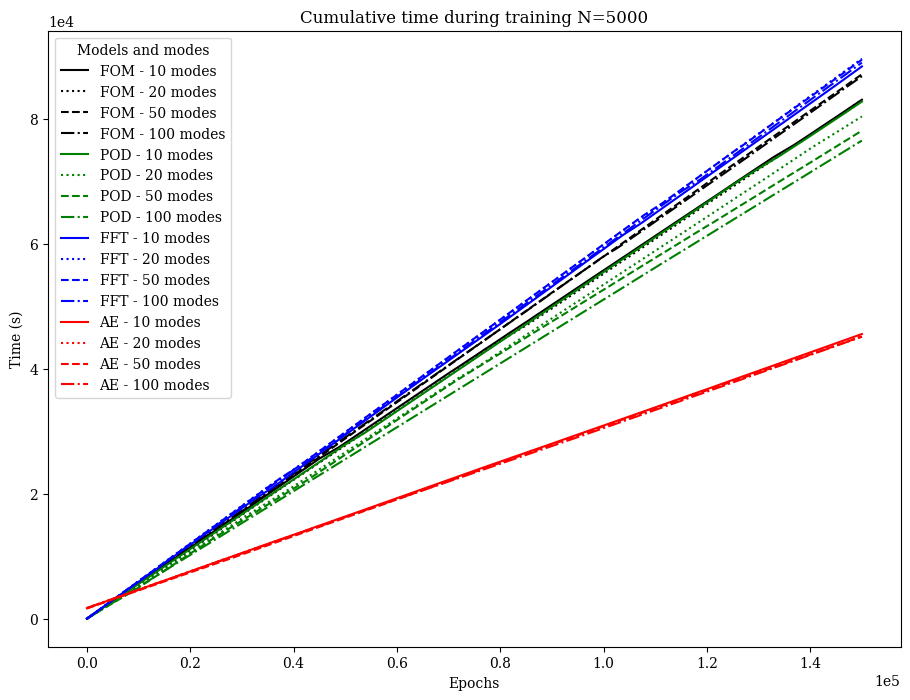

In [32]:
Ns = [5000]
Rs = [0]

names = [f'non_linear_{N}_{R}' for N in Ns for R in Rs]
modes = [10, 20, 50, 100]
models = ['baseline_model_', 'POD_model_', 'FFT_model_', 'model_autoencoder_NN_']
models = ['baseline_model_', 'POD_model_', 'FFT_model_', 'model_autoencoder_NN_']

# Diccionarios de colores y tipos de línea
colors = {
    'baseline_model_': 'black',
    'POD_model_': 'green',
    'FFT_model_': 'blue',
    'model_autoencoder_NN_': 'red'
}

name = {
    'baseline_model_': 'FOM',
    'POD_model_': 'POD',
    'FFT_model_': 'FFT',
    'model_autoencoder_NN_': 'AE'
}

line_styles = {
    1: (0, (1, 1)),     # Línea con puntos muy pequeños
    2: (0, (2, 2)),     # Línea con guiones cortos
    5: (0, (5, 2)),     # Línea con guiones más largos
    10: '-',            # Línea sólida para 10 modos
    20: ':',            # Línea punteada para 20 modos
    50: '--',           # Línea discontinua para 50 modos
    100: '-.'           # Línea de puntos y guiones para 100 modos
}

scatter_format = {
    1: '^',        # Triángulo hacia arriba para 1 modo
    2: 'x',        # Cruz para 2 modos
    5: 'p',        # Pentágono para 5 modos
    10: 'o',       # Círculo para 10 modos
    20: 's',       # Cuadrado para 20 modos
    50: 'v',       # Triángulo hacia abajo para 50 modos
    100: 'd'       # Rombo para 100 modos
}
            

fig, ax = plt.subplots(figsize=(11, 8))
# axins1 = inset_axes(ax, width="40%", height="35%", loc='lower right', borderpad=3)
# axins2 = inset_axes(ax, width="40%", height="35%", loc='lower left', borderpad=3)

for model_i in models:
    for mode_i in modes:
        for name_i in names:
            
            data_name = name_i
            n_modes = mode_i

            # Creamos los paths para las distintas carpetas
            ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
            DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
            RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
            MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(n_modes)

            # Train data splitting in train/test
            X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
            y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
            K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
            f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

            X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

            # Data processing and adequacy with our TensOps library
            X_train = X_train.to(DEVICE)
            X_test = X_test.to(DEVICE)

            y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            # Loading and processing validation data
            X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
            y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
            K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
            f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

            # Predictive network architecture
            input_shape = X_train[0].shape
            predictive_layers = [20, 10, n_modes, 10, 20]
            predictive_output = y_train.values[0].shape

            # Explanatory network architecture
            explanatory_input = Mx(My(y_train)).values[0].shape
            explanatory_layers = [10]
            explanatory_output = Mx(My(f_train)).values[0].shape

            # Other parameters
            n_filters_explanatory = 5

            if model_i == 'baseline_model_':
                
                model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                time_list = lists['time_list']
                train_total_loss_list = lists['train_total_loss_list']
                test_total_loss_list = lists['test_total_loss_list']

                cumtime = np.cumsum(time_list)

            elif model_i == 'POD_model_':
                try:
                    U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1).T, full_matrices=False)
                    U_reduced_train = U_train[:, :mode_i]
                    S_reduced_train = S_train[:mode_i]
                    Vt_reduced_train = Vt_train[:mode_i, :]
                    POD_base = torch.mm(U_reduced_train, torch.diag(S_reduced_train)).to(DEVICE)
                    model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                    with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                        time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                    time_list = lists['time_list']
                    train_total_loss_list = lists['train_total_loss_list']
                    test_total_loss_list = lists['test_total_loss_list']

                    cumtime = np.cumsum(time_list) + time_pod

                except:
                    pass

            elif model_i == 'FFT_model_':

                model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                time_list = lists['time_list']
                train_total_loss_list = lists['train_total_loss_list']
                test_total_loss_list = lists['test_total_loss_list']

                cumtime = np.cumsum(time_list)

            elif model_i == 'model_autoencoder_NN_':

                MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(n_modes)
                MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(n_modes)

                autoencoder_input_shape = y_train.values[0].shape
                latent_space_dim = [20, 10, n_modes, 10, 20]
                autoencoder_output_shape = y_train.values[0].shape

                autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                time_ae = np.cumsum(lists['time_list'])[-1]

                pretrained_encoder = autoencoder.encoder
                pretrained_decoder = autoencoder.decoder

                pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

                optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                time_list = lists['time_list']
                train_total_loss_list = lists['train_total_loss_list']
                test_total_loss_list = lists['test_total_loss_list']

                cumtime = np.cumsum(time_list) + time_ae
            
            else:
                raise ValueError("Not available.")   
            
            # Gráfico principal
            ax.plot(range(len(cumtime)), cumtime, label=f"{name[model_i]} - {mode_i} modes", color=colors[model_i], linestyle=line_styles[mode_i])
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Time (s)')
            ax.set_title(f'Cumulative time during training N={Ns[0]}')
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 1))
            ax.legend(title=f"Models and modes", loc="best")

#             axins1.scatter(name[model_i], cumtime[-1], color=colors[model_i], marker=scatter_format[mode_i], label=f"{mode_i} modes")
#             axins1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1))


# legend_elements = [
#     Line2D([], [], marker=marker, linestyle='None', markersize=7,
#            markerfacecolor=colors.get(key, 'black'), markeredgecolor='black',
#            label=f'{key} modes')
#     for key, marker in scatter_format.items()
# ]

# axins1.legend(handles=legend_elements, loc="best")


# # Inset 2: zoom al final con escala log en X y Y
# last_epochs = 5000
# axins2.plot(range(len(cumtime) - last_epochs, len(cumtime)), cumtime[-last_epochs:], 
#             label=f"{name[model_i]} - {mode_i} modes", color=colors[model_i], linestyle=line_styles[mode_i])
# axins2.set_xscale('log')
# axins2.set_yscale('log')
# axins2.set_title("End", fontsize=10)

# # Personalizar formato de los ticks en el segundo inset
# axins2.xaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
# axins2.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
# axins2.xaxis.set_major_formatter(LogFormatter(base=10.0))
# axins2.yaxis.set_major_formatter(LogFormatter(base=10.0))


plt.show()

10
20
50
100


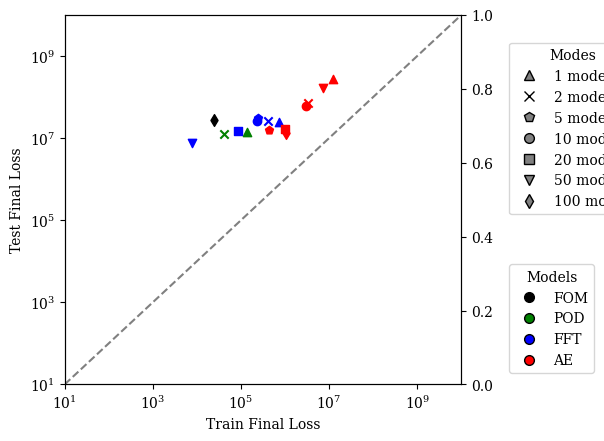

In [ ]:
Ns = [10]
Rs = [0]

names = [f'non_linear_{N}_{R}' for N in Ns for R in Rs]
modes = [1, 2, 5, 10, 20, 50, 100]
models = ['baseline_model_', 'FFT_model_', 'POD_model_', 'model_autoencoder_NN_']
# models = ['model_autoencoder_NN_']


# Diccionarios de colores y tipos de línea
colors = {
    'baseline_model_': 'black',
    'POD_model_': 'green',
    'FFT_model_': 'blue',
    'model_autoencoder_NN_': 'red'
}

name = {
    'baseline_model_': 'FOM',
    'POD_model_': 'POD',
    'FFT_model_': 'FFT',
    'model_autoencoder_NN_': 'AE'
}

line_styles = {
    1: (0, (1, 1)),     # Línea con puntos muy pequeños
    2: (0, (2, 2)),     # Línea con guiones cortos
    5: (0, (5, 2)),     # Línea con guiones más largos
    10: '-',            # Línea sólida para 10 modos
    20: ':',            # Línea punteada para 20 modos
    50: '--',           # Línea discontinua para 50 modos
    100: '-.'           # Línea de puntos y guiones para 100 modos
}

scatter_format = {
    1: '^',        # Triángulo hacia arriba para 1 modo
    2: 'x',        # Cruz para 2 modos
    5: 'p',        # Pentágono para 5 modos
    10: 'o',       # Círculo para 10 modos
    20: 's',       # Cuadrado para 20 modos
    50: 'v',       # Triángulo hacia abajo para 50 modos
    100: 'd'       # Rombo para 100 modos
}

opacity_data = {
    10: 0.5,        # Triángulo hacia arriba para 1 modo
    20: 0.7,        # Cruz para 2 modos
    50: 1,        # Pentágono para 5 modos
    # 100: 'o',       # Círculo para 10 modos
    # 1000: 's',       # Cuadrado para 20 modos
    # 5000: 'v',       # Triángulo hacia abajo para 50 modos
}

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Crear un único eje derecho

for model_i in models:
    for mode_i in modes:
        for name_i in names:
            
            data_name = name_i
            n_modes = mode_i

            # Creamos los paths para las distintas carpetas
            ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
            DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
            RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
            MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(n_modes)

            # Train data splitting in train/test
            X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
            y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
            K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
            f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

            X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

            # Data processing and adequacy with our TensOps library
            X_train = X_train.to(DEVICE)
            X_test = X_test.to(DEVICE)

            y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
            f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

            # Loading and processing validation data
            X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
            y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
            K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
            f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

            # Predictive network architecture
            input_shape = X_train[0].shape
            predictive_layers = [20, 10, n_modes, 10, 20]
            predictive_output = y_train.values[0].shape

            # Explanatory network architecture
            explanatory_input = Mx(My(y_train)).values[0].shape
            explanatory_layers = [10]
            explanatory_output = Mx(My(f_train)).values[0].shape

            # Other parameters
            n_filters_explanatory = 5

            if model_i == 'baseline_model_':
                try:
                    color = 'black'

                    model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                    time_list = lists['time_list']
                    train_total_loss_list = lists['train_total_loss_list']
                    test_total_loss_list = lists['test_total_loss_list']

                    cumtime = np.cumsum(time_list)
                except:
                    pass
            elif model_i == 'POD_model_':
                try:
                    color = 'green'

                    U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1).T, full_matrices=False)
                    U_reduced_train = U_train[:, :mode_i]
                    S_reduced_train = S_train[:mode_i]
                    Vt_reduced_train = Vt_train[:mode_i, :]
                    POD_base = torch.mm(U_reduced_train, torch.diag(S_reduced_train)).to(DEVICE)
                    model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                    with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                        time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                    time_list = lists['time_list']
                    train_total_loss_list = lists['train_total_loss_list']
                    test_total_loss_list = lists['test_total_loss_list']

                    cumtime = np.cumsum(time_list) + time_pod
                except:
                    pass
                
            elif model_i == 'FFT_model_':
                try:
                    color = 'blue'

                    model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                    time_list = lists['time_list']
                    train_total_loss_list = lists['train_total_loss_list']
                    test_total_loss_list = lists['test_total_loss_list']

                    cumtime = np.cumsum(time_list)
                except:
                    pass
            elif model_i == 'model_autoencoder_NN_':
                try:
                    color = 'red'

                    MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(n_modes)
                    MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(n_modes)

                    autoencoder_input_shape = y_train.values[0].shape
                    latent_space_dim = [20, 10, n_modes, 10, 20]
                    autoencoder_output_shape = y_train.values[0].shape

                    autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                    autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                    time_ae = np.cumsum(lists['time_list'])[-1]

                    pretrained_encoder = autoencoder.encoder
                    pretrained_decoder = autoencoder.decoder

                    pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                    explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                    optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                    model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                    time_list = lists['time_list']
                    train_total_loss_list = lists['train_total_loss_list']
                    test_total_loss_list = lists['test_total_loss_list']

                    cumtime = np.cumsum(time_list) + time_ae
                    # cumtime = np.cumsum(time_list)
                except:
                    pass
            else:
                raise ValueError("Not available.")            
            

            # # Eje izquierdo
            # ax1.plot((smooth_curve(test_total_loss_list)), color=color, label='Test Loss')
            # ax1.set_ylabel('Test Total Loss (log scale)', color='tab:blue')
            # ax1.set_yscale('log')
            # ax1.tick_params(axis='y', labelcolor='tab:blue')
            # ax1.set_xscale('log')
            # ax1.set_ylim([1e2, 1e8])

            ax1.scatter(train_total_loss_list[-1], test_total_loss_list[-1], color=colors[model_i], marker=scatter_format[mode_i], label=f"{mode_i} modes")
            ax1.set_xlabel("Train Final Loss")
            ax1.set_ylabel("Test Final Loss")
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.set_xlim([1e1, 1e10])
            ax1.set_ylim([1e1, 1e10])
            # # Eje derecho
            # ax2.plot(cumtime, color=color, label='Cumulative Time')
            # ax2.set_ylabel('Cumulative Time (log scale)', color='tab:red')
            # ax2.set_yscale('log')
            # ax2.tick_params(axis='y', labelcolor='tab:red')

lims = [
    min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
    max(ax1.get_xlim()[1], ax1.get_ylim()[1]),
]
ax1.plot(lims, lims, '--', color='gray')
ax1.set_xlim(lims)
ax1.set_ylim(lims)

# Leyenda para los modos (marcadores)
legend_elements_markers = [
    Line2D([], [], marker=marker, linestyle='None', markersize=7,
           markerfacecolor='gray', markeredgecolor='black',
           label=f'{key} modes')
    for key, marker in scatter_format.items()
]

# Leyenda para los modelos (colores)
legend_elements_colors = [
    Line2D([], [], marker='o', linestyle='None', markersize=7,
           markerfacecolor=color, markeredgecolor='black',
           label=name[i])
    for i, color in colors.items()
]



# get the current axis
ax = plt.gca()
# Shink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


# Leyenda superior (modos)
legend1 = ax1.legend(handles=legend_elements_markers, loc=2, 
                     bbox_to_anchor=(1.05, 1), borderaxespad=2, title="Modes")
ax1.add_artist(legend1)

# Leyenda inferior (modelos)
legend2 = ax1.legend(handles=legend_elements_colors, loc=2, 
                     bbox_to_anchor=(1.05, 0.4), borderaxespad=2, title="Models")

# Muestra la gráfica
plt.show()